Reproduce: SimPEG 1D
====================

## Simulating Transient TEM Data over a Conductive and Susceptible Layered Earth

Transient TEM data are simulated over a conductive 1D layered Earth. The Earth consists of 3 layers all with electrical conductivities of $\sigma_1$ = $\sigma_2$ = $\sigma_3$ = 0.01 S/m. From the top layer down we define magnetic susceptibilities of $\chi_1$ = 0 SI, $\chi_2$ = 9 SI and $\chi_3$ = 0 SI for the layers. The thicknesses of the top two layers are both 64 m.

The transient response is simulated for x, y and z oriented magnetic dipoles at (0, 0, 5). The x, y and z components of H and dB/dt are simulated at (10, 0, 5). However, we only plot the data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

## SimPEG Package Details

See https://em1dtm.readthedocs.io/en/latest/content/theory.html for short description

*Reference:* Stanley H Ward and Gerald W Hohmann. Electromagnetic Theory for Geophysical Applications. In Electromagnetic Methods in Applied Geophysics, chapter 4, pages 130–311. Society of Exploration Geophysicists, 1 edition, 1988. URL: http://library.seg.org/doi/abs/10.1190/1.9781560802631.ch4, doi:10.1190/1.9781560802631.ch4.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from SimPEG.utils import plot_1d_layer_model, mkvc

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({"font.size": 16})
write_output = True

Here we define the layered Earth model.

Text(0.5, 1.0, 'Susceptibility Model')

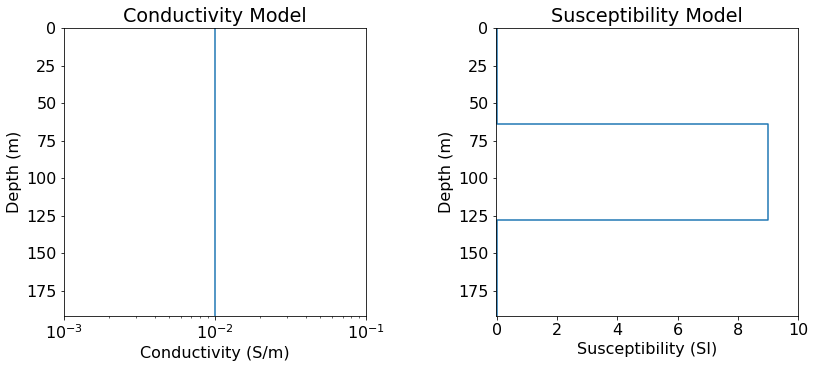

In [2]:
rootdir = './../../../assets/tdem/layered_earth_susceptible_fwd_simpeg/'

thicknesses = np.r_[64., 64]         # thicknesses (m)
sigma = np.r_[0.01, 0.01, 0.01]      # conductivity (S/m)
chi = np.r_[0., 9., 0.]              # susceptibiliity (SI)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
ax1 = plot_1d_layer_model(thicknesses, sigma, ax=ax1)
ax1.set_xlim([0.001, 0.1])
ax1.set_xlabel('Conductivity (S/m)')
ax1.set_title('Conductivity Model')

ax2 = fig.add_axes([0.6, 0.1, 0.35, 0.8])
ax2 = plot_1d_layer_model(thicknesses, chi, ax=ax2, scale='linear')
ax2.set_xlim([-0.05, 10])
ax2.set_xlabel('Susceptibility (SI)')
ax2.set_title('Susceptibility Model')

Here, we define the survey geometry for the forward simulation.

In [3]:
xyz_tx = np.r_[0., 0., 5.]           # Transmitter location
xyz_rx = np.c_[10., 0., 5.]          # Receiver location
times = np.logspace(-5,-2,10)        # Times

In [4]:
# Waveform
waveform = tdem.sources.StepOffWaveform(offTime=0.0)

# Receivers
receivers_list = [
    tdem.receivers.PointMagneticField(xyz_rx, times, "x"),
    tdem.receivers.PointMagneticField(xyz_rx, times, "y"),
    tdem.receivers.PointMagneticField(xyz_rx, times, "z"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "x"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "y"),
    tdem.receivers.PointMagneticFluxTimeDerivative(xyz_rx, times, "z")
]

source_list = []

for comp in ['X','Y','Z']:
    
    source_list.append(
        tdem.sources.MagDipole(receivers_list, location=xyz_tx, orientation=comp, waveform=waveform)
    )

# Define survey
survey = tdem.Survey(source_list)

Finally, we simulate the predicted data for the model provided.

In [5]:
simulation = tdem.simulation_1d.Simulation1DLayered(
    survey=survey, thicknesses=thicknesses, sigmaMap=maps.IdentityMap(nP=len(sigma))
)

mu0 = 4*np.pi*1e-7
mu_model = mu0 * (1 + chi)
simulation.mu = mu_model

dpred = simulation.dpred(sigma)
dpred = dpred.reshape((3, 6, len(times)))
dpred = [dpred[ii, :, :].T for ii in range(0, 3)]

D:\Documents\Repositories\geoana\geoana\kernels\tranverse_electric_reflections.py:37: RuntimeWarning: overflow encountered in tanh
  tanh = np.tanh(u[:-1]*thicknesses[:, None, None])


We can export the data to a simple text file if desired.

In [6]:
if write_output:
    
    fname_analytic = rootdir + 'dpred_1d.txt'
    
    header = 'TIME HX HY HZ DBDTX DBDTY DBDTZ'
    
    t_column = np.kron(np.ones(3), times)
    dpred_out = np.c_[t_column, np.vstack(dpred)]

    fid = open(fname_analytic, 'w')
    np.savetxt(fid, dpred_out, fmt='%.6e', delimiter=' ', header=header)
    fid.close()

## Plotting Simulated Data

Here, we plot the H and dB/dt data for horizontal coaxial, horizontal coplanar and vertical coplanar geometries.

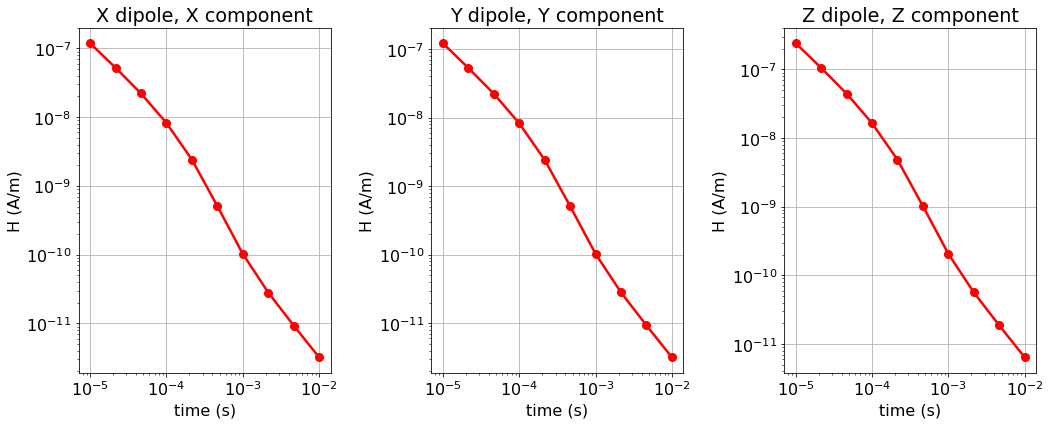

In [7]:
fig = plt.figure(figsize=(14, 6))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):

    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    ax1[ii].loglog(times, dpred[ii][:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('time (s)')
    ax1[ii].set_ylabel('H (A/m)'.format(comp))
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')

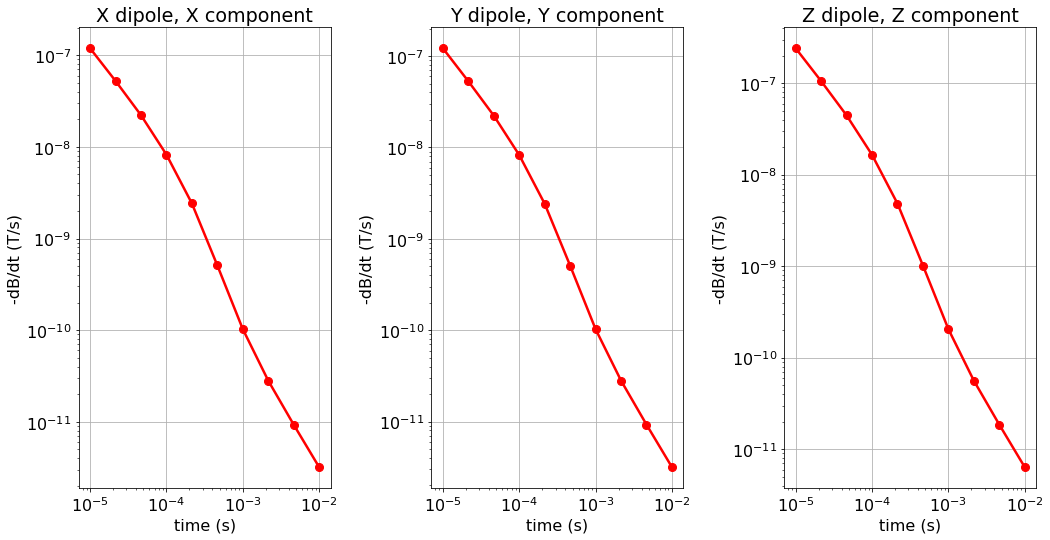

In [8]:
fig = plt.figure(figsize=(14, 8))
lw = 2.5
ms = 8

ax1 = 3*[None]

for ii, comp in enumerate(['X','Y','Z']):

    ax1[ii] = fig.add_axes([0.05+0.35*ii, 0.1, 0.25, 0.8])
    ax1[ii].loglog(times, dpred[ii][:, ii], 'r-o', lw=lw, markersize=8)
    ax1[ii].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
    ax1[ii].grid()
    ax1[ii].set_xlabel('time (s)')
    ax1[ii].set_ylabel('-dB/dt (T/s)'.format(comp))
    ax1[ii].set_title(comp + ' dipole, ' + comp + ' component')